In [0]:
!unzip dataset.zip

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CartpoleNet(nn.Module):

  def __init__(self):
    super(CartpoleNet, self).__init__()
    # 6 output channels, 3x3 square convolution
    self.conv1 = nn.Conv3d(num_channels, 6, (1, 3, 3))
    self.fc1 = nn.Linear(6 * 2 * 63 * 63, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 20)
    self.fc4 = nn.Linear(20, 4)
    self.JHist = []

  def forward(self, x):
    # Max pooling over a (2, 2, 2) window
    x = F.max_pool3d(F.relu(self.conv1(x)), 2)
    # print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

# images_per_set = 5
# num_samples = 10
# num_channels = 1

# net = CartpoleNet()
# print(net)
# input = torch.randn(num_samples, num_channels, images_per_set, 128, 128)
# out = net(input)
# print(out)

In [13]:
if __name__ == '__main__':
  from dataloader import CartpoleDataset
  import numpy as np
  torch.autograd.set_detect_anomaly(True)
  NUM_EPOCHS = 220
  # NUM_EPOCHS = 100
  LEARNING_RATE = 0.0001
  E = 50  # epoch length
  n = 5  # images per set
  W = 128  # image width
  H = 128  # image height
  grayscale = True

  if not grayscale:
    num_channels = 3
  else:
    num_channels = 1

  net = CartpoleNet().float()
  full_dataset = CartpoleDataset('data.csv', './image_dataset/', n, grayscale=grayscale)

  for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    print("Epoch {}".format(epoch))
    e = epoch * 50  # current epoch beginning index
    current_epoch_imageset = torch.empty(E-n+1, num_channels, n, W, H)
    current_epoch_labelset = torch.empty(E-n+1, 4)
    for i in range(e+n-2, e+E-2):
      k = i-(e+n-2)
      current_epoch_imageset[k, :] = full_dataset[i][0]
      current_epoch_labelset[k] = torch.from_numpy(full_dataset[i][1][n-2])
    
    criterion = nn.SmoothL1Loss()
    optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

    optimizer.zero_grad()

    pred_labelset = net(current_epoch_imageset)

    loss = criterion(pred_labelset, current_epoch_labelset)
    loss.backward()
    optimizer.step()

    print("Loss: {}".format(loss.item()))
    epoch_loss += loss.item()
    net.JHist.append(epoch_loss)


Epoch 0
Loss: 3.9941070079803467
Epoch 1
Loss: 9.993160247802734
Epoch 2
Loss: 12.347611427307129
Epoch 3
Loss: 3.2687759399414062
Epoch 4
Loss: 2.0790185928344727
Epoch 5
Loss: 1.3179210424423218
Epoch 6
Loss: 3.414477586746216
Epoch 7
Loss: 0.9468591809272766
Epoch 8
Loss: 1.214989185333252
Epoch 9
Loss: 2.4632315635681152
Epoch 10
Loss: 1.821502685546875
Epoch 11
Loss: 1.6059502363204956
Epoch 12
Loss: 1.3886008262634277
Epoch 13
Loss: 1.1419774293899536
Epoch 14
Loss: 1.0572682619094849
Epoch 15
Loss: 0.9645595550537109
Epoch 16
Loss: 2.044222354888916
Epoch 17
Loss: 1.6586105823516846
Epoch 18
Loss: 1.3776816129684448
Epoch 19
Loss: 0.8401864767074585
Epoch 20
Loss: 0.941038966178894
Epoch 21
Loss: 2.4127156734466553
Epoch 22
Loss: 0.38915351033210754
Epoch 23
Loss: 0.701890766620636
Epoch 24
Loss: 1.650901436805725
Epoch 25
Loss: 2.205808401107788
Epoch 26
Loss: 0.970267653465271
Epoch 27
Loss: 0.500434398651123
Epoch 28
Loss: 1.4016599655151367
Epoch 29
Loss: 1.063294768333435
E

[3.9941070079803467, 9.993160247802734, 12.347611427307129, 3.2687759399414062, 2.0790185928344727, 1.3179210424423218, 3.414477586746216, 0.9468591809272766, 1.214989185333252, 2.4632315635681152, 1.821502685546875, 1.6059502363204956, 1.3886008262634277, 1.1419774293899536, 1.0572682619094849, 0.9645595550537109, 2.044222354888916, 1.6586105823516846, 1.3776816129684448, 0.8401864767074585, 0.941038966178894, 2.4127156734466553, 0.38915351033210754, 0.701890766620636, 1.650901436805725, 2.205808401107788, 0.970267653465271, 0.500434398651123, 1.4016599655151367, 1.063294768333435, 1.3336913585662842, 0.9699122309684753, 0.9485820531845093, 1.0698826313018799, 0.8225001692771912, 1.055853009223938, 0.5327245593070984, 0.8243151307106018, 0.5789952278137207, 0.8452019691467285, 0.5187576413154602, 0.6652424335479736, 0.44319599866867065, 0.5470062494277954, 0.639070451259613, 0.6791892051696777, 0.8969030976295471, 0.6356723308563232, 0.4917139708995819, 1.2720897197723389, 0.951457142

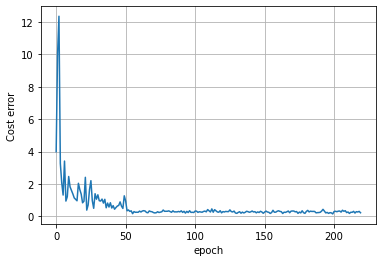

In [14]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, NUM_EPOCHS-1, NUM_EPOCHS), net.JHist)
print(net.JHist)
plt.ylabel("Cost error")
plt.xlabel("epoch")
plt.grid()
plt.show()

In [0]:
PATH = './CartpoleNet_nishant.pth'
torch.save(net.state_dict(), PATH)